1a) It is generally necessary to marginalize over latent variables as marginalizing allows for the reduction of dimensionality in the MLE, in that the diffferent parameters of each Gaussian would be more simple to calculate using latent variables that are margnalized in order to define the prior probability of obsreving a point from that Gaussian (mixing coefficient). 
1b) It is often difficult to compute the maximum likelihood solution for models with latent variables because in the MLE, the ln is typically used in order to simpilify the calculation, but with latent variables included in order to define for the mixing coefficients the ln no longer acts directly on the Gaussian, and the MLE solution for the parameters will not have a closed-form analytical solution.
1c) The goal of EM is to find MLE/MAP solutions for models with latent variables. EM overcomes the mathematical difficulty described for these solutions through the method of inferring the likely values of a latent variable, and maximize this expectation of this function under the posterior over the latent variable. This replaces marginalization with an expectation, which is much easier to calculate.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def plotCurrent(X, Rnk, Kmus):
    N, D = X.shape
    K = Kmus.shape[0]

    InitColorMat = np.array([[1, 0, 0],
                             [0, 1, 0],
                             [0, 0, 1],
                             [0, 0, 0],
                             [1, 1, 0],
                             [1, 0, 1],
                             [0, 1, 1]])

    KColorMat = InitColorMat[0:K,:]

    colorVec = np.dot(Rnk, KColorMat)
    muColorVec = np.dot(np.eye(K), KColorMat)
    plt.scatter(X[:,0], X[:,1], c=colorVec)

    plt.scatter(Kmus[:,0], Kmus[:,1], s=200, c=muColorVec, marker='d')
    plt.axis('equal')
    plt.show()

In [2]:
def calcSqDistances(X, Kmus): 
    res = np.zeros((X.shape[0], Kmus.shape[0]))
    for i in range(X.shape[0]):
        for j in range(Kmus.shape[0]):
            res[i, j] = np.linalg.norm(X[i] - Kmus[j])
    return res

In [3]:
def determineRnk(sqDmat): 
    res = np.zeros((sqDmat.shape[0], sqDmat.shape[1]))
    for i in range(sqDmat.shape[0]):
        temp = np.argmin(sqDmat[i])
        res[i, temp] = 1
    return res

In [4]:
def recalcMus(X, Rnk): 
    recalc = np.zeros((Rnk.shape[1], X.shape[1]))
    
    for i in range(Rnk.shape[1]):
        recalc[i,:] = np.sum((np.asarray([Rnk[:,i], Rnk[:,i]]).T * X), axis = 0)/(np.sum(Rnk[:,i], axis = 0))
    return recalc

In [5]:
import numpy as np
import time

def runKMeans(K,fileString):
    #load data file specified by fileString from Bishop book
    X = np.loadtxt(fileString, dtype='float')
    #print(X)

    #determine and store data set information
    N, D = X.shape

    #allocate space for the K mu vectors
    Kmus = np.zeros((K, D))

    #initialize cluster centers by randomly picking points from the data
    rand_inds = np.random.permutation(N)
    Kmus = X[rand_inds[0:K],:]

    #specify the maximum number of iterations to allow
    maxiters = 1000

    for iter in range(maxiters):
        #assign each data vector to closest mu vector as per Bishop (9.2)
        #do this by first calculating a squared distance matrix where the n,k entry
        #contains the squared distance from the nth data vector to the kth mu vector

        #sqDmat will be an N-by-K matrix with the n,k entry as specfied above
        sqDmat = calcSqDistances(X, Kmus)

        #given the matrix of squared distances, determine the closest cluster
        #center for each data vector

        #R is the "responsibility" matrix
        #R will be an N-by-K matrix of binary values whose n,k entry is set as
        #per Bishop (9.2)
        #Specifically, the n,k entry is 1 if point n is closest to cluster k,
        #and is 0 otherwise
        Rnk = determineRnk(sqDmat)

        KmusOld = Kmus
        #plotCurrent(X, Rnk, Kmus)
        time.sleep(1)

        #recalculate mu values based on cluster assignments as per Bishop (9.4)
        Kmus = recalcMus(X, Rnk)





        #check to see if the cluster centers have converged.  If so, break.
        if np.sum(np.abs(KmusOld.reshape((-1, 1)) - Kmus.reshape((-1, 1)))) < 1e-6:
            print(iter)
            break

    #plotCurrent(X, Rnk, Kmus)
    return Kmus

In [6]:
# def calRespons(X, K, mu_old, cov_old, prior_old): 
    
#     for i in range(1000):
    
#         N = len(X)
#         h = np.zeros((N, K), dtype = np.float32) #clusters
#         for i in range(K):
#             h[:,i] = recalcParams(x, mu_old[i], cov_old[i]) * prior_old[i]

#         h = np.divide(h, np.sum(h, axis = 1, keepdims = True))
#         prior_new = np.sum(h, axis = 0)/N
#         mu_new = np.divide(h.T @ X, np.sum(h, axis = 0, keepdims = True).T)
#         cov_temp = np.zeros((K, X.shape[0]))

#         for i in range(K):
#             cov_temp[i] = np.divide(h[:,i].T @ ((X - mu_new[i]) * ((X - mu_new[i]))), np.sum(h[:,i]))
#         cov_new = np.zeros((K, X.shape[0], X.shape[0]))

#         for i in range(K):
#             cov_new[i] = np.diag(cov_temp[i])

#         if np.linalg.norm(mu_new - mu_old) < 1e-3:
#             break

#         prior_old, mu_old, cov_old = prior_new, mu_new, cov_new

#     return prior_new, mu_new, cov_new

In [7]:
def gaussian(x, mu, cov):
    d = x.shape[1]
    mu = mu[None, :]
    dr = 1/(np.sqrt((2 * np.pi)**(d)*np.linalg.det(cov)))
    nr = (np.exp(-np.diag((x - mu) @ (np.linalg.inv(cov)) @ ((x - mu).T) / 2)))
    return nr * dr

In [8]:
def calcRespons(X, pi, mu, cov, K):
    num = np.zeros((X.shape[0], K))
    for i in range(K):
        num[:,i] = pi[i] * gaussian(X, mu[i], np.diag(cov[i]))
    denom = np.sum(num, axis = 1, keepdims = True)
    return np.divide(num, denom)

In [22]:
def runGMM(K, file, pi_old, kmus_old, cov_old): 
    X = np.loadtxt(file, dtype = 'float')
    N, D = X.shape
    
    #initialize mu, pi, cov
    
    #kmus_old = runKMeans(K, file)
    #pi_old = np.asarray([1/K]*K)
    #cov_old = np.zeros((2, 2))
    #for i in range(len(cov_old)):
        #cov_old[i] = np.asarray([2,3])
        
    gam = np.zeros((N, K))
    
    for i in range(1000):
        gam = calcRespons(X, pi_old, kmus_old, cov_old, K)
        pi = np.sum(gam, axis = 0) / N
        kmus = np.zeros((K, D))
        for i in range(K):
            kmus[i] = np.divide((gam.T @ X)[i], np.sum(gam[:,i]))
        cov = np.zeros((K, D))
        for i in range(K):
            cov[i] = np.divide((gam[:, i ].T @ ((X - kmus[i]) ** 2)), np.sum(gam[:,i]))
        
        #This line is important. It prevents your covariance matrix from becoming singular
        
        cov[cov < 0.01] = 0.03
        if np.linalg.norm(kmus - kmus_old) < 1e-3:
            break
    
        pi_old, kmus_old, cov_old = pi, kmus, cov
        
    
    
    return pi_old, kmus_old, cov_old, gam

In [23]:
#params
pi_old = np.asarray([1/2] * 2)
mu_old = runKMeans(2, 'scaledfaithful.txt')
cov = np.zeros((2,2))
for i in range(len(cov)):
    cov[i] = np.asarray([2,3])

3


In [24]:
pi, mu, cov, gam = runGMM(2, 'scaledfaithful.txt', pi_old, mu_old, cov)

In [25]:
pi

array([0.3565489, 0.6434511])

In [26]:
mu

array([[-1.2702141 , -1.20656122],
       [ 0.70385059,  0.66857928]])

In [27]:
cov

array([[0.05404456, 0.18267853],
       [0.12901224, 0.1935001 ]])

In [28]:
gam

array([[1.51564889e-11, 1.00000000e+00],
       [1.00000000e+00, 1.29723946e-12],
       [5.36133033e-07, 9.99999464e-01],
       [9.99999732e-01, 2.67884255e-07],
       [9.73744235e-26, 1.00000000e+00],
       [9.99919426e-01, 8.05741419e-05],
       [2.98440077e-29, 1.00000000e+00],
       [1.60124630e-13, 1.00000000e+00],
       [1.00000000e+00, 9.42556270e-13],
       [4.27065234e-23, 1.00000000e+00],
       [1.00000000e+00, 1.90087241e-12],
       [5.43275414e-17, 1.00000000e+00],
       [1.02227134e-18, 1.00000000e+00],
       [1.00000000e+00, 5.27433548e-15],
       [1.36216389e-27, 1.00000000e+00],
       [1.00000000e+00, 3.63990928e-11],
       [1.00000000e+00, 2.32156260e-10],
       [1.77611443e-29, 1.00000000e+00],
       [1.00000000e+00, 3.74881808e-14],
       [9.99211854e-20, 1.00000000e+00],
       [1.00000000e+00, 1.54388077e-13],
       [1.00000000e+00, 5.27433548e-15],
       [1.51453887e-09, 9.99999998e-01],
       [9.78703739e-03, 9.90212963e-01],
       [3.904688

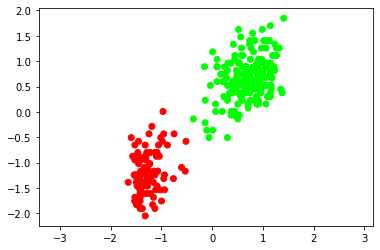

In [30]:
plotCurrent(np.loadtxt("scaledfaithful.txt"), gam, mu)